## Topological properties of graphs & graph clustering


__BMI/CS 775: Computation Network Biology__ <br>
October 17th, 2024 <br>
Spencer Halberg-Spencer & Erika Lee <br>
https://compnetbiocourse.discovery.wisc.edu 

Today's lecture will cover: 
1. Commonly measured network properties
    1. Degree distribution
    2. Modularity of biological networks
2. Algorithms to find modules on graphs
    1. Louvain clustering
    2. Spectral clustering
    3. Hierarchical clustering 

This jupyter notebook will act as an aid and explanation of each of these learning objectives. 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from sklearn.cluster import KMeans
import scipy as sp
import math
import igraph as ig
import pandas as pd
from ipywidgets import interact, IntSlider, FloatSlider, interactive

### Degree Distributions

Our first learning objective is to explore the degree distributions of graphs. Recall the node degree distribution is defined as the following. 
* Undirected network: the degree of node $i$ is defined as the number of edges that connect $i$ to a neighbor, $j$. Alternately, the degree of node $i$ is the number of edges connected to node $i$. 
* Directed network: we consider an edge $<i,j>$ outgoing from node $i$ and incoming to node $j$. We can consider two values for directed networks. 
    * In degree: For node $j$, it is the number of edges that are incoming to node $j$. 
    * Out degree: For node $i$, it is the number of edges that are outgoing from node $i$. 

We can quantify global properperties of the graph using node degrees. The most straightforward measure of the connectivity of a graph is the average degree. Consider an undirected graph with $N$ nodes. Let $k_i$ denote the degree of node $i$. The average degree is: 

$$<k> = \frac{\sum_{i=1}^{N} k_i}{N}$$ 

While this measure gives a simple way of comparing graphs, it does not indicate the variability of degree among nodes within a single network. This variability is an important property of graphs, especially when trying to identify nodes which are highly connected. Instead, we can consider the *degree distribution*. 

* Degree distribution : The probability $P(k)$ that a node has $k$ edges. Generally this is computed empirically for a given graph.

We can compare the distribution between graphs to get a better understanding of how nodes are connected globally.  Today we will cover two improtant degree distributions: the Poisson distribution and the power law (scale-free distribution). 

### Poisson distributions and Erdos-Renyi Graphs
The Poisson distribution is a discete distribution parameterized by the following equation: 

$$ P( X = k ) = \frac{\lambda^{k}e^{-\lambda}}{k!}$$  

A few important points about the poisson distribution and graph degree: 
* $\lambda$ represents the expected value of $X$, as well as the variance of $X$. 
* We can estimate $\lambda$ using the maximum likelihood estimator, which is equivelent to the average node degree, $\lambda_{MLE} = \frac{\sum_{i=1}^{N} k_i}{N}$
* The MLE estimator of $\lambda$ is an unbiased estimator of $\lambda$. This works well when $N$ is sufficiently large.   


An *Erdos-Renyi graph* is a graph generated from a probalilistic process. Given $N$ nodes, the graph generation model is specified by the probability that an edge exists between two nodes with probability $p$. Such graphs have Poisson degree distributions.

The Erdos-Renyi graph generation models is implemented in the igraph package. We will be useing the following implementation *ig.Graph.Erdos_Renyi(n, p, directed, loops)*. This implementation takes in the following parameters: 
1. n: The number of nodes in the graph. 
2. p: The probability that an edge exists between any two nodes. The probability of a given edges is indepedent of all other edges. 
3. directed: A boolean indicating if we want an directed or undirected graph. (default = False). 
4. loops: If we want the graph to include edges that exist between a single node, eg (i, i). (default = False). 

In the next code block, I generated four different graphs with 30 nodes, and varying probabilities of an edge.

In [2]:
g1 = ig.Graph.Erdos_Renyi(n = 30, p = 0.05, directed = False, loops = False)
g2 = ig.Graph.Erdos_Renyi(n = 30, p = 0.10, directed = False, loops = False)
g3 = ig.Graph.Erdos_Renyi(n = 30, p = 0.25, directed = False, loops = False)
g4 = ig.Graph.Erdos_Renyi(n = 30, p = 0.40, directed = False, loops = False)



fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
axs[0, 0].set_title('n = 30, p = 0.05')
axs[0, 1].set_title('n = 30, p = 0.10')
axs[1, 0].set_title('n = 30, p = 0.25')
axs[1, 1].set_title('n = 30, p = 0.40')

ig.plot(
    g1,
    target=axs[0, 0],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g2,
    target=axs[0, 1],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g3,
    target=axs[1, 0],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g4,
    target=axs[1, 1],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)
plt.show()

AttributeError: 'VertexCollection' object has no property 'offset_transform'

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 864x720 with 4 Axes>

We can explore distribution of each plot using the plot_degree_dist function below. This function takes in an igraph object and generates a normalized histogram which displays the probability of observing a node with degree i. This distribution is estimated empirically for each graph. 

We can compare the emipirically estimated distribution to the estimated Poisson distribution for each graph. The probability mass function for the Poisson distribution can be added to a plot using the plot_poisson function below. 

In [4]:
### Define a function that plots the degree distribution for a given graph. 
def plot_degree_dist(igraph_obj):
    degree = igraph_obj.degree() 
    ### Give a vector which denotes the degree of each node. 
    plt.hist(degree, [ x - 0.5 for x in range(0, max(degree) + 2, 1)], density = True, color = 'black') ## Make bins surronding each integer and count the number of nodes with each degree.
    plt.xlim(right = max(degree)+ 0.5 )
    if(max(degree) <= 10):    
        plt.xticks([x for x in range(0, max(degree)+1)])  ## With small degree, we can enumerate all values on axis. 
        
### Define a function that plots the poisson probability mass function (the equation from above)
def plot_poisson(l, max_disp):
    x  = np.arange(0, max_disp+1)
    ## Computed by hand so you can see how. Math fact, will overflow for relatively small k so we need to also include the a call to the stats package. 
    if(max_disp <= 50):
        prob = [(l**k) * np.exp(-l) / math.factorial(k) for k in x]
        plt.plot(x, prob, 'rx--') ### Plot the poisson distribution 
    else:
        ## This also just computes the poisson probability distribution but we don't worry about overflow. 
        prob = sp.stats.poisson.pmf(x, mu = l)   
        plt.plot(x, prob, 'r--')
    
            

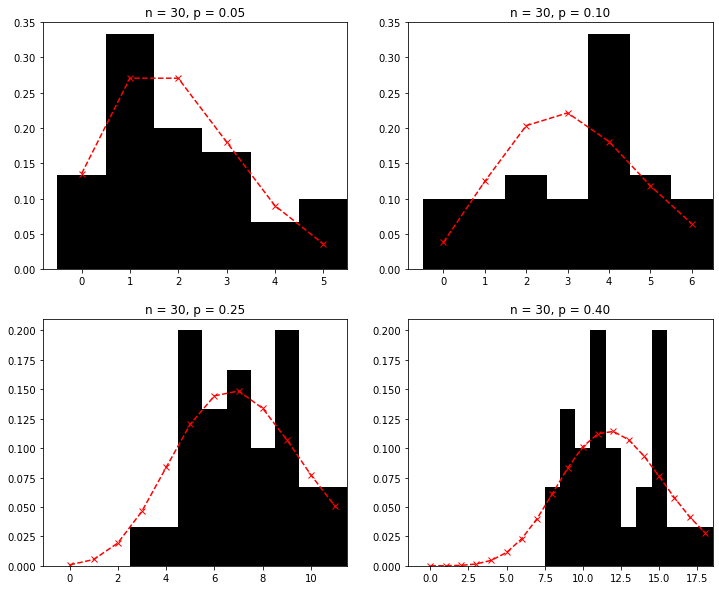

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
plt.sca(axs[0,0]) ## Set active plot 
axs[0,0].set_title('n = 30, p = 0.05')
plot_degree_dist(g1)
plot_poisson(np.mean(g1.degree()), max(g1.degree()))


plt.sca(axs[0,1]) ## Set active plot 
axs[0, 1].set_title('n = 30, p = 0.10')
plot_degree_dist(g2)
plot_poisson(np.mean(g2.degree()), max(g2.degree()))


plt.sca(axs[1,0]) ## Set active plot 
axs[1, 0].set_title('n = 30, p = 0.25')
plot_degree_dist(g3)
plot_poisson(np.mean(g3.degree()), max(g3.degree()))

plt.sca(axs[1,1]) ## Set active plot 
axs[1, 1].set_title('n = 30, p = 0.40')
plot_degree_dist(g4)
plot_poisson(np.mean(g4.degree()), max(g4.degree()))

In [5]:

# Function to generate Erdos-Renyi graph and plot results
def plot_erdos_renyi_graph(n, p):
    # Generate a random Erdos-Renyi graph
    graph = ig.Graph.Erdos_Renyi(n=n, p=p)

    # Get degree distribution
    degrees = graph.degree()
    mean_degree = np.mean(degrees)

    # Plot the graph
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 10)

    # Plot 1: Graph visualization
    ig.plot(graph, target=axs[0], vertex_size=3, edgewidth = 0.15,  layout='kk')
    plt.title("Erdos-Renyi Graph")

    # Plot 2: Histogram of node degree distribution and Poisson distribution
    plt.sca(axs[1]) ## Set active plot 
    plt.hist(degrees, bins=np.arange(min(degrees)-.5, max(degrees) + 1.5, 1), density=True, alpha=0.6, color='b', label='Degree Distribution')

    # Poisson distribution with lambda = mean degree
    poisson_dist = sp.stats.poisson.pmf(np.arange(0, max(degrees) + 1), mu = mean_degree)  
    
    plt.plot(np.arange(0, max(degrees) + 1), poisson_dist, 'r-', lw=2, label=f'Poisson(λ={mean_degree:.2f})')

    plt.title('Degree Distribution with Poisson Fit')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
interact(plot_erdos_renyi_graph, 
         n=IntSlider(min=30, max=500, step=10, value=100, description='Number of Nodes'),
         p=FloatSlider(min=0.01, max=.99, step=0.01, value=0.05, description='Edge Probability'))



interactive(children=(IntSlider(value=100, description='Number of Nodes', max=500, min=30, step=10), FloatSlid…

<function __main__.plot_erdos_renyi_graph(n, p)>

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 864x720 with 2 Axes>

<div style="background-color: lightblue; padding: 10px;">

#### Questions

1. In Erodos-Renyi Graph generation process, what distribution describes the degree of each node? 

2. As the number of nodes increases, the degree distribution of the graph apporaches a Poisson distribution. For what values of n and p do you feel the degree distribution is well estimated by the Poisson distribution? 

3. What is the behavior of the edge distribution at the extreme values of p? When p = 1.0 what distribution do the degrees follow? What is the total number of edges when p = 1.0? 
    
 </div>

### Power law and scale free networks 

An alternative degree distribution follows the power law distribution. These networks, often called *scale-free* networks, describe many real-world networks. These graphs are characterized by hubs of of highly connected nodes, and overall short path lengths between nodes. The probability mass function is defined as 

$$ P(X = k ) \propto k^{-\gamma} $$ 

where $\gamma$ is a constant usually between 2 and 3. This distrubution means most nodes will only be connected by 1 edge and a few nodes will have most of the edges in the graph. We can generate approximate scale free networks using a graph generation process called the Barabosi-Albert model. The Barabasi-Arbert model is implemented with the following iGraph function: *ig.Graph.Barabasi(n, m, loops = False)* where the input parameters indicate: 
* n - the total number of vertices
* m - the number of outgoing edges generated for each vertex, or a list containing the number of outgoing edges for each vertex. 

The implementation of the algorithm is described in this seminal paper: Barabási, A-L and Albert, R. 1999. Emergence of scaling in random networks. Science, 286 509-512

Briefly, the model is a static time-based generation model. At each time step, a new node is added. Then, from the set of existing nodes, m nodes are sampled. The probability that a node is sampled is proportional to its current degree, such that highly connected nodes are more likely to get additional edges. 

$$p_i = \frac{k_i}{\sum_j k_j}$$

This results in higher probability for nodes which are already heavily linked, resulting in an accumulation of edges at these hub nodes.

Below is a graph generation process with $n = 20$, and $m = 2$. At each step two nodes are selected by random using the probability defined above. Note the highly connected natiure of the second and third node that are added to the graph. The gif was prepared by Harvath Arpad, in preparation for the NetworkX module in python. 

![Barabási–Albert model](Barabasi_Albert_model.gif)

<div style="background-color: lightblue; padding: 10px;">

#### Question   
* Below are four graphs which have been generated useing the Barabasi algorithm. Describe how increasing m changes the structure of the graph.  
    
</div>    

In [14]:
g1 = ig.Graph.Barabasi(30, 1) 
g2 = ig.Graph.Barabasi(30, 2) 
g3 = ig.Graph.Barabasi(30, 5) 
g4 = ig.Graph.Barabasi(30, 20) 

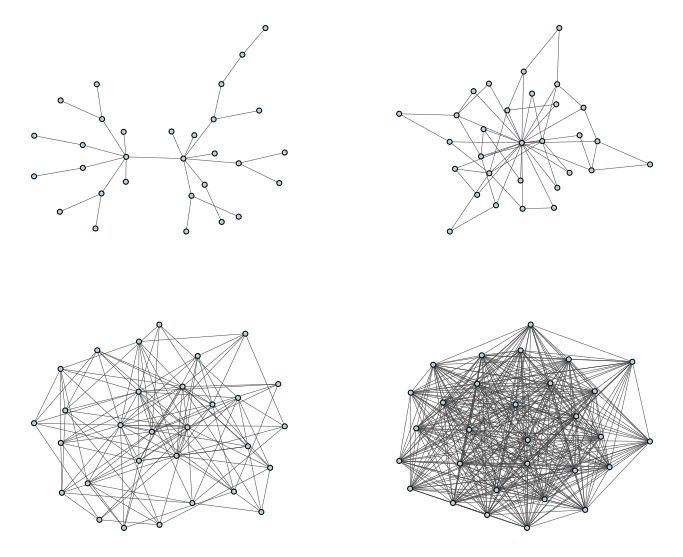

In [15]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
ig.plot(
    g1,
    target=axs[0, 0],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)

ig.plot(
    g2,
    target=axs[0, 1],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5,
    edge_width = 0.5
)

ig.plot(
    g3,
    target=axs[1, 0],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)
ig.plot(
    g4,
    target=axs[1, 1],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)

Next I have prepared a widget that generates graphs using the Barabasi algorithm. On the left is the generated graph and on the right is the degree distribution. Note we plot the degree distribution on a log-log scale, in which a power-law relationship is represented as a straight line. Shown on the degree distributon plot is a fitted power law function and the reported $\gamma$ value. 

In [6]:
import ipywidgets as widgets

def update_graph(num_nodes, num_edges):
    g = ig.Graph.Barabasi(num_nodes, num_edges)
    degrees = np.array(g.degree())
    degree_counts = np.bincount(degrees)

    # Prepare data for fitting the power-law
    non_zero_degrees = np.arange(len(degree_counts))[degree_counts > 0]
    log_degrees = np.log(non_zero_degrees)
    log_counts = np.log(degree_counts[degree_counts > 0])

    # Fit the power-law using scipy.stats
    slope, intercept, _, _, _ = sp.stats.linregress(log_degrees, log_counts)

    # Plot the results
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 10)
    
    ig.plot(g, target=axs[0], vertex_size=5, edgewidth = 0.15,  layout='kk', vertex_color="lightblue")
    plt.title("Barabasi-Albert Model")
    
    
    plt.loglog(non_zero_degrees, degree_counts[degree_counts > 0], marker='o', linestyle='None', label='Empirical Data')
    plt.loglog(non_zero_degrees, np.exp(intercept) * non_zero_degrees ** slope, 
               color='b', linestyle='--', label='Fitted Power-law')
    plt.title(f'Degree Distribution with Power-law Fit, gamma: {-slope:.2f}')
    plt.xlabel('Degree (k)')
    plt.ylabel('Count P(k)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create sliders for parameters
num_nodes_slider = widgets.IntSlider(value=5, min=5, max=150, step=10, description='Number of Nodes:')
num_edges_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Edges per Node:')

# Link the update function to the sliders
widgets.interactive(update_graph, num_nodes=num_nodes_slider, num_edges=num_edges_slider)


interactive(children=(IntSlider(value=5, description='Number of Nodes:', max=150, min=5, step=10), IntSlider(v…

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Describe the relationship between the wellness of fit of the power-law function and number of nodes in the network. 
2. Describe the relationhsip between the wellness of fit of the power-law function and the sampling number (m) in the network. 
3. Compare and contrast the graphs generated by the Barabasi algorithm and the Erdos-Renyi algorithm. 
</div>    

### Investigating a gene regulatory network for a fungal species (A. fumigatus)

Now we will look at a gene regulatory network (GRN) generated by MERLIN-p. The MERLIN-p algorithm takes in a set of bulk RNA-seq data and infers a GRN. We will not cover the details of the model here but a reference to the paper can be found below:

Alireza F. Siahpirani, Sushmita Roy, A prior-based integrative framework for functional transcriptional regulatory network inference, Nucleic Acids Research, Volume 45, Issue 4, 28 February 2017, Page e21, https://doi.org/10.1093/nar/gkw963

In a recent study, I have applied an extension of MERLIN-p to a collection of publicly available Aspergillus Fumigatus RNA-seq data to a infer a GRN, whose properties we will now investigate. A detailed description of the inferred network and its properties can be found in the bioRxiv preprint below: 

Cristobal Carrera Carriel, Saptarshi Pyne, Spencer A. Halberg-Spencer, et al.,A network-based model of Aspergillus fumigatus elucidates regulators of development and defensive natural products of an opportunistic pathogen bioRxiv 2023.05.11.538573; doi: https://doi.org/10.1101/2023.05.11.538573

In [7]:
df = pd.read_csv("GRASP_output_net_0_8_sorted.txt", sep= '\t', header=None, names=["source", "target", "weight"])

### We need the graph to have ids which are defined based on integers 
unique_vertices = pd.concat([df['source'], df['target']]).unique()  # Get unique vertex names
vertex_map = {vertex: idx for idx, vertex in enumerate(unique_vertices)}  # Create mapping

# Step 3: Convert source and target columns to their corresponding numeric indices
df['source'] = df['source'].map(vertex_map)
df['target'] = df['target'].map(vertex_map)

### Convert from dataframe to igraph. 
g = ig.Graph.DataFrame(df, directed=True)

g.es['weight'] = df['weight'].tolist()
g.vs["name"] = unique_vertices

In [8]:
g.summary()

'IGRAPH DNW- 5086 6497 -- \n+ attr: name (v), weight (e)'

The inferred GRN has a total of 5086 genes (nodes) and 6597 edges. Below is a visualization of the inferred graph and the degree distirbution of the inferred network.  

In [9]:
fig.set_size_inches(12, 10) 
ig.plot(g, 
        edge_arrow_size=0.5, 
        vertex_size=5, 
        edgewidth = 0.15,  
        layout='kk', 
        vertex_color="lightblue")

AttributeError: Plotting not available; please install pycairo or cairocffi

In [10]:
degrees = np.array(g.degree())
degree_counts = np.bincount(degrees)

# Prepare data for fitting the power-law
non_zero_degrees = np.arange(len(degree_counts))[degree_counts > 0]
log_degrees = np.log(non_zero_degrees)
log_counts = np.log(degree_counts[degree_counts > 0])
slope, intercept, _, _, _ = sp.stats.linregress(log_degrees, log_counts)

    
plt.loglog(non_zero_degrees, degree_counts[degree_counts > 0], marker='o', linestyle='None', label='Empirical Data')
plt.loglog(non_zero_degrees, np.exp(intercept) * non_zero_degrees ** slope, 
               color='b', linestyle='--', label='Fitted Power-law')
plt.title(f'Degree Distribution with Power-law Fit, gamma: {-slope:.2f}')
plt.xlabel('Degree (k)')
plt.ylabel('Count P(k)')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'sp' is not defined

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Would you describe the inferred GRN as scale-free? 
2. What does the inferred GRN structure tell us about gene regulation? 
     
</div>    

### Module detection in the Karate Club network

Next we will explore community detection in the karate club network. This network connects 34 members of a karate club at a US university in the 1970s. The 78 edges represent the relationship between individuals in the karate club. The graph was first cited in this paper: 

W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

We will use this network to explore clustering and community detection within graphs. A community is a group of nodes. The metric and method we use to group nodes in a graph poses an unsupervised learning problem. Different approaches may be better in different contexts. 

In [11]:
karate = ig.Graph.Famous("Zachary")
print(karate.summary())

layout = karate.layout('kk')

ig.plot(karate, 
        vertex_size=20,
        layout = layout, 
        edgewidth = 0.15,  
        vertex_color="lightblue")

IGRAPH U--- 34 78 -- 


AttributeError: Plotting not available; please install pycairo or cairocffi

### Louvain and Leiden clustering

Louvain and Leiden clustering belong to a class of graph clustering algorithms widely used in the biomedical domain. They utilize a metric called *modularity* to define optimimal clusters. As optimizing the modularity of a graph is an NP-hard problem, the two algorithms utilize greedy approaches. We will not go into the details of the implementation of these agorithms or their differences; here is a great review for additional reading: 

Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

Modularity is defined as: 

$$ Q = \frac{1}{2m} \sum_{i,j} \left[ A_{i,j} - \frac{{k_i}{k_j}}{2m} \right] \delta(c_i, c_j) $$ 

Here $m$ represents the total sum of the edge weights (or the number of edges in an unweighted, undirected network); $k_i$ represents the degree of node $i$; $\delta()$ is an indicator which equals 1 if node $i$ is in the same cluster as node $j$. The Leiden algorithm is implemented in the igraph framework using the *community_leiden(resolution)*. Increasing the resolution of parameter will increase the number of clusters, i.e. have more resolved communities. 

In [15]:
def plot_leiden_clusters(resolution):
    
    communities = karate.community_leiden(resolution = resolution)
    n_pal = len(communities)
    palette = ig.RainbowPalette(n=n_pal)
    for i, community in enumerate(communities):
        karate.vs[community]["color"] = i
    
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    )

In [16]:
plot_leiden_clusters(0.1)

AttributeError: 'VertexCollection' object has no property 'offset_transform'

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 432x288 with 1 Axes>

In [17]:
resolution_slider = widgets.FloatSlider(value=0.01, min=0.01, max=2.0, step=.01, description='Resolution')
# Link the update function to the sliders
widgets.interactive(plot_leiden_clusters, resolution=resolution_slider)

interactive(children=(FloatSlider(value=0.01, description='Resolution', max=2.0, min=0.01, step=0.01), Output(…

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 432x288 with 1 Axes>

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. How does resolution change the clustering result? 
    
2. How would you determine the best or the most suitable clustering result from different resolutions?
     
</div>    

### Spectral clustering

The final algorithm that we will explore is spectral clustering. Spectral clustering utilizes the the graph Laplacian, which is a matrix that captures the intrinsic properties of a graph. A graph can be represented as an adjacendy matrix $A$, where each entry $A_{i,j}$ denotes the existence of an edge or the edge weight between node $i$ and node $j$.

The standard graph Laplacian $L$ is calculated using $A$ and $D$. $D$ is diagonal matrix in which each diagonal element is the degree of the node, i.e. $D_{i,i} = \sum_j A_{i,j}$.

$$ L = D - A $$ 


There are other ways of constructing the graph Laplacian, e.g. the normalized Graph Laplacian. You can look up these other versions and learn about why they might be used in different situations.

Spectral clustering follow the steps:
1. Define the graph Laplacian matrix. 
2. Compute the eigenvector representation of the Laplacian. 
3. Select the first k eigenvectors as node embeddings.
4. Cluster the nodes using the eigenvector-based embeddings, using a clustering algorithm like k-means.

The algorithm is implemented below.

In [18]:
def spectral_clustering(graph, clusters, normalized = False): 
    ## find the laplacian matrix
    laplacian = graph.laplacian(normalized = normalized)
    eig_vals, eig_vects = np.linalg.eigh(laplacian) ## we can use eigh for symetric graphs and its faster! 
    best_eigens = [ i for i in range(clusters)]
    LX = eig_vects[:,best_eigens]  ## select these eign vectors  
    ## Normalize the eig vect rowwise. 
    LX = (LX.T / np.linalg.norm(LX, axis=1)).T
    
    ## Cluster with kmeans 
    km = KMeans(n_clusters=clusters, n_init=20)
    km.fit(LX)
    y_pred = km.labels_
    graph.vs["color"] = y_pred
    
def plot_sectral_clusters(k):
    ## Perform Spectral clustering on karate
    spectral_clustering(karate, k)
    
    palette = ig.RainbowPalette(k)
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    ) 

In [19]:
k_slider = widgets.IntSlider(value=2, min=2, max=33, step=1, description='K')
# Link the update function to the sliders
widgets.interactive(plot_sectral_clusters, k=k_slider)

interactive(children=(IntSlider(value=2, description='K', max=33, min=2), Output()), _dom_classes=('widget-int…

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 432x288 with 1 Axes>

In [20]:
def plot_sectral_clusters(k):
    ## Perform Spectral clustering on karate
    spectral_clustering(karate, k, normalized = True)
    
    palette = ig.RainbowPalette(k)
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    ) 
    
k_slider = widgets.IntSlider(value=2, min=2, max=33, step=1, description='K')
# Link the update function to the sliders
widgets.interactive(plot_sectral_clusters, k=k_slider)

interactive(children=(IntSlider(value=2, description='K', max=33, min=2), Output()), _dom_classes=('widget-int…

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 432x288 with 1 Axes>

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Which k would you select to best represent the structure in the karate club graph? 

2. How does using the normalized Laplacian (bottom) differ from using the standard Laplacian (top)? 
    
3. What are the similarities and differences between the clusters from Leiden and Spectral clustering?
</div>    

### Hierarchical clustering and the Girvan-Newman algorithm

The Girvan-Newman algorithm uses *betweenness* as an indicator of nodes and edges that are critical or central to connecting a network. We can think about betweenness as a measure of how important or necessary a node or an edge is for connecting the shortest paths between pairs of nodes. *Node (or edge) betweenness* is the proportion of shortest paths in the network that the given node (edge) is part of. 

The algorithm follows these steps: 
1. Calculate the betweenness of all edges.
2. Remove the edges with the highest betweenness. 
3. Update the betweenness of all edges affected by the removal.
4. Repeat step 2 and 3 until all edges are removed. 

The algorithm generates a dendrogram from root to leaves (i.e., top-down clustering). The leaves of the dendrogram represent individual nodes, and the inner branches represent community of nodes which are still connected.

In [13]:
def girvan_newman(g):
    # Create a copy of the graph to modify
    graph = g.copy()
    
    #### identify the connected comps
    comps = graph.components()
    num_comps = len(comps)
    palette = ig.RainbowPalette(n=num_comps)
    for i, community in enumerate(comps):
        graph.vs[community]["color"] = i
    
    ### identify edge color 
    edge_betweenness = graph.edge_betweenness()
    max_betweenness = max(edge_betweenness)
    min_betweenness = min(edge_betweenness)
    
    if(len(edge_betweenness) > 0):
        edge_colors = [plt.cm.viridis((eb - min_betweenness) / (max_betweenness - min_betweenness)) for eb in edge_betweenness]
        graph.es["color"] = edge_colors
    
    
    # Store the initial graph object. 
    subgraphs = list()
    copy_graph = graph.copy()
    subgraphs.append(copy_graph)
    
    
    while len(graph.es) > 0 :
        ## Find Edge to remove
        edge_betweenness = graph.edge_betweenness()
        max_betweenness_index = np.argmax(edge_betweenness)
        graph.delete_edges(max_betweenness_index)

        
        
        #### identify the connected comps
        comps = graph.components()
        num_comps = len(comps)
        palette = ig.RainbowPalette(n=num_comps)
        for i, community in enumerate(comps):
            graph.vs[community]["color"] = i
        
        # Recompute edge_betweenness 
        edge_betweenness = graph.edge_betweenness()
     
        # Store the initial graph object.
        if(len(edge_betweenness) > 0): ## Need edges
            max_betweenness = max(edge_betweenness)
            min_betweenness = min(edge_betweenness)
            
            if(max_betweenness - min_betweenness > 0 ):
                edge_colors = [
                    plt.cm.viridis(1 - (eb - min_betweenness) / (max_betweenness - min_betweenness)) for eb in edge_betweenness
                ]
                graph.es["color"] = edge_colors
        
        copy_graph = graph.copy()
        subgraphs.append(copy_graph)
    return subgraphs


def plot_graphs(index):
    subgraph = subgraphs[index]
    n_pal = max(subgraph.vs["color"]) + 1
    palette = ig.RainbowPalette(n=n_pal)
    
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(30, 10)
    
    ig.plot(subgraph,
        edge_color = 'grey', 
        layout = layout,
        target = axs[1],
        palette = palette,
        vertex_label = list(range(subgraph.vcount())),
        vertex_size = 20, 
    )

    ig.plot(subgraph, 
        layout = layout, 
        vertex_color = "grey",
        vertex_size = 20,
        vertex_label = list(range(subgraph.vcount())), 
        target = axs[0])
    
    dendro = karate.community_edge_betweenness(directed=False, clusters = n_pal)
    #clusters = dendro.as_clustering()
    #node_pal = palette[subgraph.vs["color"]]
    ig.plot(dendro, target = axs[2], orientation = "top-bottom")


In [14]:
subgraphs = girvan_newman(karate)

num_edges_slider = widgets.IntSlider(value=0, min=0, max=len(subgraphs)-1, step=1, description='Edges removed')
# Link the update function to the sliders
widgets.interactive(plot_graphs, index=num_edges_slider)

interactive(children=(IntSlider(value=0, description='Edges removed', max=78), Output()), _dom_classes=('widge…

AttributeError: 'VertexCollection' object has no property 'offset_transform'

<Figure size 2160x720 with 3 Axes>

In the visualization above, we can see how the node communities are determined based on the edge betweenness. The first panel represents the edge betweenness score. Higher edge betweenness is indicated by brighter (yellow) color.  At each iteration we remove the edge with the highest betweenness; in the first iteration, this is the edge between nodes 0 and 31. After 11 edges are removed, we have the first split in the dendrogram that creates two communities. This process is repeated until all edges are removed and each node is assigned to its own single-node cluster. 

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. How would you decide the optimal threshold to define clusters in the dendrogram, i.e. which level of the tree to use? 
    
2. In the example above, node 9 splits off to its own single-node cluster relatively early. What might this say about node 9's properties?
    
3. Which of the three clustering algorithms do you think works best on the karate club graph? Why? 
        
</div>    

<div style="background-color: lightgreen; padding: 10px;">

#### Challenge
    
In the space below, select one of the three clustering algorithms from above and explore clustering on a large GRN or another biological network. Consider the following:  

1. How are you defining what yields "good" clusterings of the network? 
2. How do you determine the correct number of clusters?
3. If you are clustering on a GRN: what might each gene cluster represent? How would you evaluate whether these gene clusters contain biologically meaningful information? 

</div>    